In [214]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import json
#from scipy import stats
#import scipy.interpolate as interp
from pprint import pprint
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 14

In [215]:
import FEMmodule as FEM

# Toy FEM - python version

This code is the Python replica of the matlab code used in *LAB01* of the course **Nonlinear Analysis of Aerospace Structures** held by Marco Morandini, Riccardo Vescovini at *Politecnico di Milano*

## Build matrices

- *nodes* matrix: containing nodes coordinates
- *elements* matrix: connectivity matrix associating nodes to elements
- *constrained elements* vector: list of constrained (fixed) nodes

Parameters are **nx** and **ny**: number of elements in *x* and *y* directions.

Default plate size is l=10, w=2. It can be changes passing additional parameters to **Nodes**

In [216]:
nx = 2
ny = 2
l = 10.
w = 2.

In [217]:
nodes, elements, constr_nodes = FEM.Nodes(nx,ny)
#nodes, elements, constr_nodes = FEM.Nodes(nx,ny, l, w)

Create a Gaussian integrator for **2D** 2$\times$2 matrix

In [218]:
GI = FEM.GaussIntegr2D2x2()

Create a *plane stress* **Elastic Tensor** with parameters **E** and **$\nu$**

In [219]:
E = FEM.PlaneStressElasticTensor(1.e4, 0.3)

Create a set of *bilinear weights*, used to interppolate a **2D** function on a $(x,y)$ grid

In [220]:
W = FEM.BilinearWeights()

Build vectors of *constrained* and *free* **DOFs**

In [221]:
constr_dofs = np.append(constr_nodes, constr_nodes + nodes.shape[0])
free_dofs = np.array([i for i in range(0,2*nodes.shape[0]) if i not in constr_dofs])

Build matrices

In [222]:
ne = nodes.shape[0]*nodes.shape[1]
GlobalStiff = np.zeros((ne,ne))
GlobalRes = np.zeros(ne)
GlobalDispl = np.zeros_like(GlobalRes)

**Force** vector: $[F_x , F_y]$

In [223]:
force = np.array([0. ,1.])

Compute *global stiffness matrix* and *global resultants*:

In [224]:
for e in range(elements.shape[0]):
    act_e = elements[e,:].astype(int)
    #print "act element: ",act_e
    Stiff = GI.Integrate(lambda x : FEM.ElementLocalStiffness(nodes[act_e,:], E, W, x) )
    #print "stiffness: ",Stiff
    Res = GI.Integrate(lambda x : FEM.ElementVolumeForce(nodes[act_e,:], force, W, x) )
    conn = np.concatenate((act_e, act_e + nodes.shape[0]))
    indxs = np.ix_(conn,conn)
    GlobalStiff[indxs] = GlobalStiff[indxs] + Stiff
    GlobalRes[conn] = GlobalRes[conn] + Res

Remove *dofs* that are constrained

In [225]:
mask = np.ones(GlobalStiff.shape[0], dtype=bool)
mask[constr_dofs] = False

#pprint(GlobalStiff)
#print GlobalRes

indxs = np.ix_(mask,mask)
GlobalStiff = GlobalStiff[indxs]
GlobalRes = GlobalRes[mask]

compute node displacements

In [226]:
displ = np.linalg.solve(GlobalStiff, GlobalRes)

In [227]:
GlobalDispl[free_dofs] = displ

In [228]:
GlobalDispl = GlobalDispl.reshape(nodes.shape,order='F')

[[  0.00000000e+00   0.00000000e+00]
 [  1.35169416e-02   4.37330211e-02]
 [  1.63055457e-02   1.21316761e-01]
 [  0.00000000e+00   0.00000000e+00]
 [  3.39155390e-17   4.33516867e-02]
 [  4.35223623e-17   1.21380383e-01]
 [  0.00000000e+00   0.00000000e+00]
 [ -1.35169416e-02   4.37330211e-02]
 [ -1.63055457e-02   1.21316761e-01]]


In [229]:
def plotMesh(nodes, elements, style=None):
    c = np.array([[0,1],[1,2],[2,3],[3,0]])
    for e in range(elements.shape[0]):
        el = elements[e,:].astype(int)
        for l in range(4):
            plt.plot(nodes[el[c[l,:]],0],nodes[el[c[l,:]],1],style)

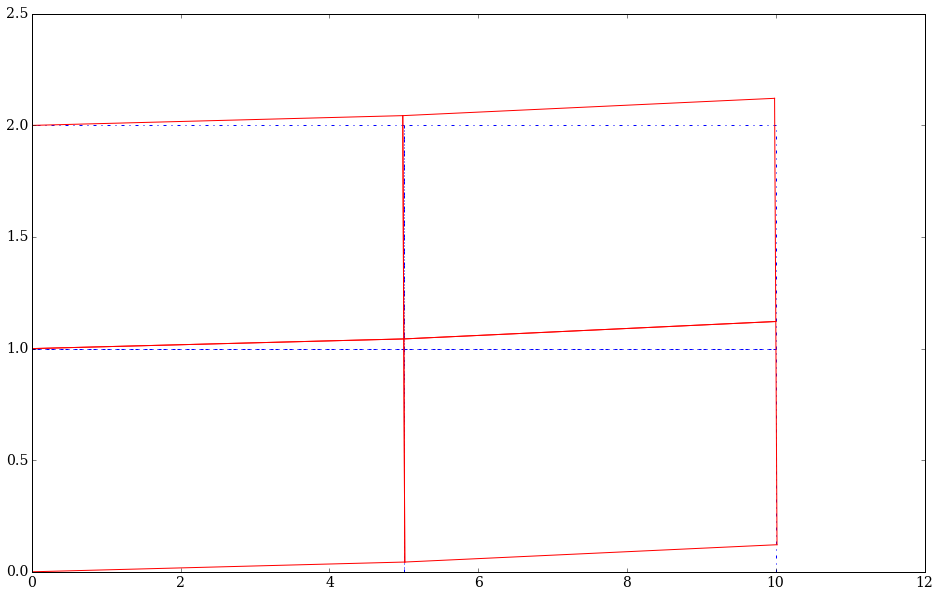

In [230]:
plt.figure(figsize=(16,10), dpi=300)
plotMesh(nodes,elements,'b-.')
plotMesh(nodes+GlobalDispl,elements,'r')